In [1]:
version #updateされた

               _                           
platform       x86_64-apple-darwin15.6.0   
arch           x86_64                      
os             darwin15.6.0                
system         x86_64, darwin15.6.0        
status                                     
major          3                           
minor          6.3                         
year           2020                        
month          02                          
day            29                          
svn rev        77875                       
language       R                           
version.string R version 3.6.3 (2020-02-29)
nickname       Holding the Windsock        

# 乳がん亜型の遺伝子発現パターン特性

# 1. TCGAデータを使おう
それぞれの患者に対し標準化された遺伝子発現と医療データを含んだ、Cancer Genome Atlas1(https://tcga-data.nci.nih.gov) から集められたデータを使う。

- ```genomicMatrix```: 1216人の患者（列）における20530もの遺伝子（行）に対する様々な遺伝子発現変数の、タブ区切りのデータ
- ```clinical_data```: それぞれの患者（行）における215もの医療データ分野（列）に対する、タブ区切りのデータ

### Rか好きな言語を使って、簡単に操作できるよう行列データ構造へと、ファイル内に記載されたデータを読み込み、メインメモリに展開せよ。
#### R言語のヒント: 
```read.table```関数を使おう。ほとんどの遺伝子は患者間で差異がなく、データセットから除くことができる。

In [2]:
# 20530もの遺伝子（行）, 1216人の患者（列）

genomicMatrix <- read.table("genomicMatrix.txt", header = TRUE, fill = FALSE, sep='\t')

# count na
na_count_genomicMatrix <- sapply(genomicMatrix, function(y) sum(is.na(y)))
#na_count_genomicMatrix #列ごとの集計結果が出てくる #0が理想で、全部0だった

In [3]:
dim(genomicMatrix) #20530 1216

[1] 20530  1216

In [4]:
#患者（行）,215もの医療データ分野（列）

clinical_data <- read.table("clinical_data.txt", header = TRUE, fill = FALSE, sep = '\t')

na_count_clinical_data_NA <- sapply(clinical_data, function(y) sum(is.na(y)))
                                    
#列ごとの集計結果が出てくる（0が理想） #欠損値沢山                                  
#na_count_clinical_data_NA

In [5]:
#clinical_dataを空白のセルをNAで補完したものにした

clinical_data <- read.table("clinical_data.txt", header = TRUE, fill = FALSE, sep = '\t', na.strings=c("", "NULL"," "))
#clinical_data

In [6]:
clinical_data[1, 'sampleID']

[1] TCGA-3C-AAAU-01
1241 Levels: TCGA-3C-AAAU-01 TCGA-3C-AALI-01 TCGA-3C-AALJ-01 ... TCGA-Z7-A8R6-01

In [7]:
dim(clinical_data) #1241 215

[1] 1241  215

### それぞれの遺伝子に対して患者間の標準偏差を計算せよ。0.5などのある特定の閾値以下の標準偏差を持つ遺伝子を除け。
#### R言語のヒント: 
R行列におけるそれぞれの行と列において関数を実行するため```apply```関数を使おう。すべての計算において'NA'変数を無視せよ。

※関数```apply``` はベクトルに対して適用できないらしい。

In [8]:
#行(遺伝子)を減らしたい

#genomicMatrixに関してですね。欠損値無いそうなので
#行ごとに調査したい
library(tidyverse)

#sample列は遺伝子名が入っているのでsd計算はできない(あるとエラーになる)
# 取り除きたい列がひとつの場合
genomicMatrix_EXsample_index <- colnames(genomicMatrix) != "sample" #sample列は数値でないので
genomicMatrix_EXsample <- genomicMatrix[genomicMatrix_EXsample_index]

sd_genomicMatrix_EXsample <- apply(genomicMatrix_EXsample,1,sd) #1...行(横に集計) 2...列(縦に集計)

#class(sd_genomicMatrix_EXsample) #'numeric' #class関数...型を知る #遺伝子の名前がなかった。
#array(sd_genomicMatrix_EXsample) #array関数...配列型にする
#dim(array(sd_genomicMatrix_EXsample)) #20530
#nrow(array(sd_genomicMatrix_EXsample)) #20530
#ncol(array(sd_genomicMatrix_EXsample)) #<NA>

─ Attaching packages ──────────────────── tidyverse 1.3.0 ─
✔ ggplot2 3.3.0          ✔ purrr   0.3.3     
✔ tibble  3.0.0          ✔ dplyr   0.8.5     
✔ tidyr   1.0.2          ✔ stringr 1.4.0.9000
✔ readr   1.3.1          ✔ forcats 0.5.0     
─ Conflicts ───────────────────── tidyverse_conflicts() ─
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


```
─ Conflicts ───────────────────── tidyverse_conflicts() ─
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
```
はデフォルトらしい。

In [9]:
#20530であるのが理想(行数が変化していない必要がある)
length(array(sd_genomicMatrix_EXsample)) #ok

[1] 20530

In [10]:
# 何番目の要素が条件を満たしているか
sdLarger_genomicMatrix_Larger0.5 <- genomicMatrix[0.5 < array(sd_genomicMatrix_EXsample), ]
#sdLarger_genomicMatrix_Larger0.5 #16799*1216

In [11]:
#20530 - 16799 = 3731

nrow(genomicMatrix) - nrow(sdLarger_genomicMatrix_Larger0.5)

[1] 3731

### clinical_dataの列```ER_Status_nature2012```と列```PR_Status_nature2012```からERとPRの状態を抜き出し、```sampleID``` fieldを使って遺伝子データにそれらを合わせよ。どのER/PR statusが知られていない遺伝子データからサンプルを除け。
#### R言語のヒント: 
arrays```my.array[, c(col1, col2)]```において多数のindex選択を使おう。

統計処理をするには因子型にしなければいけない

In [12]:
#患者（行）,215もの医療データ分野（列）
#clinical_dataに関して
df.test <- subset(clinical_data, !(is.na(clinical_data$'ER_Status_nature2012')))
clinical_data_ERPRknown <- subset(df.test, !(is.na(df.test$'PR_Status_nature2012')))

#clinical_data_ERPRknown #781 × 215

In [13]:
nrow(df.test)

[1] 782

# 2. ER and PR statusに対し遺伝子特性を見極めよ
もしERマーカー（ホルモン受容体）が陽性だったら、腫瘍はLuminal (A or B)で、陰性だったら腫瘍はHER2-typeかbasalである。

<img src = '20200317201949.png'>

### 遺伝子データとER statusを使って、すべての遺伝子に対してt検定量を計算せよ。遺伝子を選び、有意性を測るp値でランク付けせよ。

#### R言語のヒント: 
```t.test```関数を使おう(遺伝子発現データを正しい入力用の形式に変えるため```as.numeric```を使う必要があるかもしれない)。それぞれの行にある遺伝子発現変数に検定関数を適用するために、```for``` loopか```apply```を使う事もできる。

```devtools::install_github('IRkernel/repr')```によって```ERROR while rich displaying an object```を回避した

In [14]:
#sdLarger_genomicMatrix_Larger0.5を患者リスト（行）、遺伝子（列）とする

sdLarger_genomicMatrix_Larger0.5.t <- t(sdLarger_genomicMatrix_Larger0.5)
sdLarger_genomicMatrix_Larger0.5_t <- as.data.frame(t(sdLarger_genomicMatrix_Larger0.5))

geno_names_list <- list() 
for (i in 1:ncol(sdLarger_genomicMatrix_Larger0.5_t)){
    geno_names_list <- c(geno_names_list, list(as.character(sdLarger_genomicMatrix_Larger0.5_t[1, i])))
}

names(sdLarger_genomicMatrix_Larger0.5_t) <- c(geno_names_list)
sdLarger_genomicMatrix_Larger0.5_t <- sdLarger_genomicMatrix_Larger0.5_t[-1, ]


head(sdLarger_genomicMatrix_Larger0.5_t)

,ARHGEF10L,HIF3A,RNF17,RNF11,REM1,RTN4RL2,C16orf13,C16orf11,FGFR1OP2,TSKS,⋯,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
TCGA.A8.A092.01,-9.266700e-01,-4.836158e+00,-5.455592e-01,-4.253624e-01,-2.511796e+00,1.420118e+00,-7.693104e-02,-5.839527e-01,-6.495416e-02,-1.262546e+00,⋯,-7.274778e-01,-1.319172e+00,-5.342834e-01,-8.710635e-01,1.370407e-01,-4.940637e-01,-3.960971e-01,-1.178462e+00,-1.748619e+00,-6.597493e-01
TCGA.A7.A0CE.11,1.929300e-01,9.510421e-01,3.635741e+00,2.439376e-01,1.809104e+00,-5.076823e-01,-3.306310e-01,-5.839527e-01,-2.704542e-01,1.179154e+00,⋯,-1.827777e-02,2.385228e+00,7.136166e-01,-8.454635e-01,1.135407e-01,1.777436e+00,5.336029e-01,6.548380e-01,3.773381e+00,4.975069e-02
TCGA.OL.A5D7.01,1.3475300224,-2.8021579402,-0.5455592009,-2.3702623729,-0.0342955876,1.7700176800,0.9682689610,2.8800472956,-1.5558541582,1.3081536499,⋯,0.5555222346,-0.7236722855,0.8925165819,-0.6797634709,0.7743406568,-1.3835636844,-0.9973971228,-0.0275619561,0.2905811915,-0.7206493087
TCGA.D8.A1JK.01,-8.396700e-01,-3.260158e+00,4.200408e-01,7.185376e-01,-3.227956e-01,-1.267982e+00,2.528690e-01,-5.839527e-01,-3.115416e-02,-1.634746e+00,⋯,-1.652778e-01,-1.691372e+00,7.830166e-01,3.733653e-02,-5.145934e-02,7.301363e-01,1.388803e+00,1.339138e+00,-1.924519e+00,7.545069e-02
TCGA.BH.A0AY.11,-3.706998e-02,2.515742e+00,-5.455592e-01,7.566376e-01,2.250104e+00,-1.391382e+00,-1.695231e+00,-5.839527e-01,4.736458e-01,3.155365e-02,⋯,-2.066778e-01,4.979228e+00,-7.334834e-01,-1.243263e+00,3.439407e-01,2.500736e+00,2.137903e+00,-6.516196e-02,3.666481e+00,-2.521493e-01
TCGA.E2.A10C.01,-1.193700e-01,-4.646958e+00,-5.455592e-01,-4.539624e-01,-1.073796e+00,-1.506382e+00,1.084969e+00,1.680847e+00,1.014584e-02,8.906536e-01,⋯,-1.660778e-01,-1.129972e+00,-3.508834e-01,-6.818635e-01,-2.061593e-01,-4.063637e-01,3.541029e-01,-3.161956e-03,-9.037188e-01,-1.953493e-01


```"^data[[:digit:]]{1,}.txt"```に当てはまるのは、```"data1.txt"```, ```"data12.txt"```

An atomic vector is a vector with just one element. When a function is doing something like a binary operator, such as taking a difference, it complains about that.

In [15]:
　class(rownames(sdLarger_genomicMatrix_Larger0.5_t))

[1] "character"

In [16]:
#sdLarger_genomicMatrix_Larger0.5_tにsampleIDをくっつけるためのコード

#sdLarger_genomicMatrix_Larger0.5_t <- transform(sdLarger_genomicMatrix_Larger0.5_t,sampleID=c(rownames(sdLarger_genomicMatrix_Larger0.5_t)))

In [17]:
head(sdLarger_genomicMatrix_Larger0.5_t)

,ARHGEF10L,HIF3A,RNF17,RNF11,REM1,RTN4RL2,C16orf13,C16orf11,FGFR1OP2,TSKS,⋯,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
TCGA.A8.A092.01,-9.266700e-01,-4.836158e+00,-5.455592e-01,-4.253624e-01,-2.511796e+00,1.420118e+00,-7.693104e-02,-5.839527e-01,-6.495416e-02,-1.262546e+00,⋯,-7.274778e-01,-1.319172e+00,-5.342834e-01,-8.710635e-01,1.370407e-01,-4.940637e-01,-3.960971e-01,-1.178462e+00,-1.748619e+00,-6.597493e-01
TCGA.A7.A0CE.11,1.929300e-01,9.510421e-01,3.635741e+00,2.439376e-01,1.809104e+00,-5.076823e-01,-3.306310e-01,-5.839527e-01,-2.704542e-01,1.179154e+00,⋯,-1.827777e-02,2.385228e+00,7.136166e-01,-8.454635e-01,1.135407e-01,1.777436e+00,5.336029e-01,6.548380e-01,3.773381e+00,4.975069e-02
TCGA.OL.A5D7.01,1.3475300224,-2.8021579402,-0.5455592009,-2.3702623729,-0.0342955876,1.7700176800,0.9682689610,2.8800472956,-1.5558541582,1.3081536499,⋯,0.5555222346,-0.7236722855,0.8925165819,-0.6797634709,0.7743406568,-1.3835636844,-0.9973971228,-0.0275619561,0.2905811915,-0.7206493087
TCGA.D8.A1JK.01,-8.396700e-01,-3.260158e+00,4.200408e-01,7.185376e-01,-3.227956e-01,-1.267982e+00,2.528690e-01,-5.839527e-01,-3.115416e-02,-1.634746e+00,⋯,-1.652778e-01,-1.691372e+00,7.830166e-01,3.733653e-02,-5.145934e-02,7.301363e-01,1.388803e+00,1.339138e+00,-1.924519e+00,7.545069e-02
TCGA.BH.A0AY.11,-3.706998e-02,2.515742e+00,-5.455592e-01,7.566376e-01,2.250104e+00,-1.391382e+00,-1.695231e+00,-5.839527e-01,4.736458e-01,3.155365e-02,⋯,-2.066778e-01,4.979228e+00,-7.334834e-01,-1.243263e+00,3.439407e-01,2.500736e+00,2.137903e+00,-6.516196e-02,3.666481e+00,-2.521493e-01
TCGA.E2.A10C.01,-1.193700e-01,-4.646958e+00,-5.455592e-01,-4.539624e-01,-1.073796e+00,-1.506382e+00,1.084969e+00,1.680847e+00,1.014584e-02,8.906536e-01,⋯,-1.660778e-01,-1.129972e+00,-3.508834e-01,-6.818635e-01,-2.061593e-01,-4.063637e-01,3.541029e-01,-3.161956e-03,-9.037188e-01,-1.953493e-01


In [18]:
#rownamesから取っている

geno_seq_list  <- list() 
for (i in 1:nrow(sdLarger_genomicMatrix_Larger0.5_t)){
    geno_seq <- gsub("[[:punct:]]", "", rownames(sdLarger_genomicMatrix_Larger0.5_t)[i]) 
    geno_seq <- unlist(geno_seq)
    geno_seq_list <- c(geno_seq_list, list(geno_seq))
}

head(geno_seq_list)
length(geno_seq_list) #1215

[[1]]
[1] "TCGAA8A09201"

[[2]]
[1] "TCGAA7A0CE11"

[[3]]
[1] "TCGAOLA5D701"

[[4]]
[1] "TCGAD8A1JK01"

[[5]]
[1] "TCGABHA0AY11"

[[6]]
[1] "TCGAE2A10C01"

[1] 1215

In [19]:
#'sampleID'列から取っている

cli_seq_list  <- list() 
for (i in 1:nrow(clinical_data_ERPRknown)){
    cli_seq <- gsub("[[:punct:]]", "", clinical_data_ERPRknown[i, 'sampleID']) 
    cli_seq <- unlist(cli_seq)
    cli_seq_list <- c(cli_seq_list, list(cli_seq))
}

head(cli_seq_list)
length(cli_seq_list) #781

[[1]]
[1] "TCGAA1A0SB01"

[[2]]
[1] "TCGAA1A0SD01"

[[3]]
[1] "TCGAA1A0SE01"

[[4]]
[1] "TCGAA1A0SF01"

[[5]]
[1] "TCGAA1A0SG01"

[[6]]
[1] "TCGAA1A0SH01"

[1] 781

In [20]:
length(132) #1です

[1] 1

どうやら```rbind```が遅いらしい。

### dplyr
https://dplyr.tidyverse.org/reference/join.html

In [21]:
#devtools::install_version('textfeatures', version='0.2.0', repos='http://cran.us.r-project.org')

In [22]:
sdLarger_genomicMatrix_Larger0.5_t[1, ]

,ARHGEF10L,HIF3A,RNF17,RNF11,REM1,RTN4RL2,C16orf13,C16orf11,FGFR1OP2,TSKS,⋯,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
TCGA.A8.A092.01,-9.266700e-01,-4.836158e+00,-5.455592e-01,-4.253624e-01,-2.511796e+00,1.420118e+00,-7.693104e-02,-5.839527e-01,-6.495416e-02,-1.262546e+00,⋯,-7.274778e-01,-1.319172e+00,-5.342834e-01,-8.710635e-01,1.370407e-01,-4.940637e-01,-3.960971e-01,-1.178462e+00,-1.748619e+00,-6.597493e-01


In [23]:
clinical_data_ERPRknown[1, ]

,sampleID,AJCC_Stage_nature2012,Age_at_Initial_Pathologic_Diagnosis_nature2012,CN_Clusters_nature2012,Converted_Stage_nature2012,Days_to_Date_of_Last_Contact_nature2012,Days_to_date_of_Death_nature2012,ER_Status_nature2012,Gender_nature2012,HER2_Final_Status_nature2012,⋯,X_GENOMIC_ID_TCGA_BRCA_PDMRNAseq,X_GENOMIC_ID_TCGA_BRCA_G4502A_07_3,X_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2_percentile,X_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2,X_GENOMIC_ID_TCGA_BRCA_gistic2thd,X_GENOMIC_ID_TCGA_BRCA_PDMarray,X_GENOMIC_ID_TCGA_BRCA_PDMRNAseqCNV,X_GENOMIC_ID_TCGA_BRCA_hMethyl27,X_GENOMIC_ID_TCGA_BRCA_GSNP6noCNV,X_GENOMIC_ID_TCGA_BRCA_miRNA_GA
,<fct>,<fct>,<int>,<int>,<fct>,<int>,<int>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
9,TCGA-A1-A0SB-01,Stage I,70,1,Stage I,259,NA,Positive,FEMALE,Negative,⋯,TCGA-A1-A0SB-01,NA,a2405d64-34eb-4915-abf7-8530151d5cb0,a2405d64-34eb-4915-abf7-8530151d5cb0,TCGA-A1-A0SB-01A-11D-A141-01,NA,TCGA-A1-A0SB-01,NA,d4c2fab5-8fbd-4ab5-b18c-37f9b4b576a8,NA


In [24]:
#PR_..の正式名称が知りたい
grep("^PR_", colnames(clinical_data_ERPRknown))
colnames(clinical_data_ERPRknown)[22]
head(clinical_data_ERPRknown[, 22])#どんな表現があるのか知る

[1] 22

[1] "PR_Status_nature2012"

[1] Negative Positive Positive Positive Positive Positive
Levels: Indeterminate Negative Positive

In [25]:
x <- sdLarger_genomicMatrix_Larger0.5_t[1, ]
x

,ARHGEF10L,HIF3A,RNF17,RNF11,REM1,RTN4RL2,C16orf13,C16orf11,FGFR1OP2,TSKS,⋯,TULP2,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
TCGA.A8.A092.01,-9.266700e-01,-4.836158e+00,-5.455592e-01,-4.253624e-01,-2.511796e+00,1.420118e+00,-7.693104e-02,-5.839527e-01,-6.495416e-02,-1.262546e+00,⋯,-7.274778e-01,-1.319172e+00,-5.342834e-01,-8.710635e-01,1.370407e-01,-4.940637e-01,-3.960971e-01,-1.178462e+00,-1.748619e+00,-6.597493e-01


In [26]:
#ncol == 215(sampleIDが先頭についているので、クリニカルデータだけだと214)
y <- clinical_data_ERPRknown[165, ]
y

,sampleID,AJCC_Stage_nature2012,Age_at_Initial_Pathologic_Diagnosis_nature2012,CN_Clusters_nature2012,Converted_Stage_nature2012,Days_to_Date_of_Last_Contact_nature2012,Days_to_date_of_Death_nature2012,ER_Status_nature2012,Gender_nature2012,HER2_Final_Status_nature2012,⋯,X_GENOMIC_ID_TCGA_BRCA_PDMRNAseq,X_GENOMIC_ID_TCGA_BRCA_G4502A_07_3,X_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2_percentile,X_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2,X_GENOMIC_ID_TCGA_BRCA_gistic2thd,X_GENOMIC_ID_TCGA_BRCA_PDMarray,X_GENOMIC_ID_TCGA_BRCA_PDMRNAseqCNV,X_GENOMIC_ID_TCGA_BRCA_hMethyl27,X_GENOMIC_ID_TCGA_BRCA_GSNP6noCNV,X_GENOMIC_ID_TCGA_BRCA_miRNA_GA
,<fct>,<fct>,<int>,<int>,<fct>,<int>,<int>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
227,TCGA-A8-A092-01,Stage IIIA,48,2,Stage IIIA,518,NA,Positive,FEMALE,Negative,⋯,TCGA-A8-A092-01,TCGA-A8-A092-01A-11R-A00Z-07,98b2b18a-004d-459c-8aba-499d06897910,98b2b18a-004d-459c-8aba-499d06897910,TCGA-A8-A092-01A-11D-A011-01,TCGA-A8-A092-01,TCGA-A8-A092-01,TCGA-A8-A092-01A-11D-A00Y-05,d03b22fa-5bae-4247-a7fa-e8f77e38d8fd,TCGA-A8-A092-01A-11R-A010-13


In [27]:
xy <- cbind(x, y) 
xy

,ARHGEF10L,HIF3A,RNF17,RNF11,REM1,RTN4RL2,C16orf13,C16orf11,FGFR1OP2,TSKS,⋯,X_GENOMIC_ID_TCGA_BRCA_PDMRNAseq,X_GENOMIC_ID_TCGA_BRCA_G4502A_07_3,X_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2_percentile,X_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2,X_GENOMIC_ID_TCGA_BRCA_gistic2thd,X_GENOMIC_ID_TCGA_BRCA_PDMarray,X_GENOMIC_ID_TCGA_BRCA_PDMRNAseqCNV,X_GENOMIC_ID_TCGA_BRCA_hMethyl27,X_GENOMIC_ID_TCGA_BRCA_GSNP6noCNV,X_GENOMIC_ID_TCGA_BRCA_miRNA_GA
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
TCGA.A8.A092.01,-9.266700e-01,-4.836158e+00,-5.455592e-01,-4.253624e-01,-2.511796e+00,1.420118e+00,-7.693104e-02,-5.839527e-01,-6.495416e-02,-1.262546e+00,⋯,TCGA-A8-A092-01,TCGA-A8-A092-01A-11R-A00Z-07,98b2b18a-004d-459c-8aba-499d06897910,98b2b18a-004d-459c-8aba-499d06897910,TCGA-A8-A092-01A-11D-A011-01,TCGA-A8-A092-01,TCGA-A8-A092-01,TCGA-A8-A092-01A-11D-A00Y-05,d03b22fa-5bae-4247-a7fa-e8f77e38d8fd,TCGA-A8-A092-01A-11R-A010-13


In [28]:
length(geno_seq_list)

[1] 1215

In [29]:
merge_df_list <- list()

for (i in 1:length(geno_seq_list)){
    if (is.element(geno_seq_list[i], cli_seq_list)==TRUE){
        x <- sdLarger_genomicMatrix_Larger0.5_t[i, ]
        y_num <- as.integer((1:length(cli_seq_list))[geno_seq_list[i] == as.character(cli_seq_list)])
        if (length(y_num) == 1){
            y <- clinical_data_ERPRknown[y_num, ]
            xy <- cbind(x, y) #cbindだとsampleID作る必要がない
            merge_df_list <- c(merge_df_list, list(xy))
        }
    }
}

merge_df <- bind_rows(merge_df_list) #rbind_allは古い → bind_rows

In [30]:
#781×17014(16799+215)

head(merge_df)

,ARHGEF10L,HIF3A,RNF17,RNF11,REM1,RTN4RL2,C16orf13,C16orf11,FGFR1OP2,TSKS,⋯,X_GENOMIC_ID_TCGA_BRCA_PDMRNAseq,X_GENOMIC_ID_TCGA_BRCA_G4502A_07_3,X_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2_percentile,X_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2,X_GENOMIC_ID_TCGA_BRCA_gistic2thd,X_GENOMIC_ID_TCGA_BRCA_PDMarray,X_GENOMIC_ID_TCGA_BRCA_PDMRNAseqCNV,X_GENOMIC_ID_TCGA_BRCA_hMethyl27,X_GENOMIC_ID_TCGA_BRCA_GSNP6noCNV,X_GENOMIC_ID_TCGA_BRCA_miRNA_GA
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,-9.266700e-01,-4.836158e+00,-5.455592e-01,-4.253624e-01,-2.511796e+00,1.420118e+00,-7.693104e-02,-5.839527e-01,-6.495416e-02,-1.262546e+00,⋯,TCGA-A8-A092-01,TCGA-A8-A092-01A-11R-A00Z-07,98b2b18a-004d-459c-8aba-499d06897910,98b2b18a-004d-459c-8aba-499d06897910,TCGA-A8-A092-01A-11D-A011-01,TCGA-A8-A092-01,TCGA-A8-A092-01,TCGA-A8-A092-01A-11D-A00Y-05,d03b22fa-5bae-4247-a7fa-e8f77e38d8fd,TCGA-A8-A092-01A-11R-A010-13
2,-8.396700e-01,-3.260158e+00,4.200408e-01,7.185376e-01,-3.227956e-01,-1.267982e+00,2.528690e-01,-5.839527e-01,-3.115416e-02,-1.634746e+00,⋯,TCGA-D8-A1JK-01,NA,f7dd2e6b-a87e-467b-890a-3c422ae3dea7,f7dd2e6b-a87e-467b-890a-3c422ae3dea7,TCGA-D8-A1JK-01A-11D-A13J-01,NA,TCGA-D8-A1JK-01,NA,7013da0d-5e90-4f8d-a489-8077b55309b0,NA
3,-1.193700e-01,-4.646958e+00,-5.455592e-01,-4.539624e-01,-1.073796e+00,-1.506382e+00,1.084969e+00,1.680847e+00,1.014584e-02,8.906536e-01,⋯,TCGA-E2-A10C-01,TCGA-E2-A10C-01A-21R-A10J-07,1f7762ae-94bf-4ab4-a6d6-7fe57b1e1e99,1f7762ae-94bf-4ab4-a6d6-7fe57b1e1e99,TCGA-E2-A10C-01A-21D-A10L-01,TCGA-E2-A10C-01,TCGA-E2-A10C-01,NA,47ba6d6f-734a-4e33-af3e-eef3783cc26b,TCGA-E2-A10C-01A-21R-A10I-13
4,2.880300e-01,-1.599358e+00,-5.455592e-01,-2.111624e-01,-2.041396e+00,-1.561823e-01,-8.612310e-01,-5.839527e-01,-2.494542e-01,-1.029746e+00,⋯,TCGA-BH-A0C7-01,TCGA-BH-A0C7-01B-11R-A115-07,e58a6cf4-a4ff-4179-9671-a5661f380a8d,e58a6cf4-a4ff-4179-9671-a5661f380a8d,TCGA-BH-A0C7-01B-11D-A111-01,TCGA-BH-A0C7-01,TCGA-BH-A0C7-01,TCGA-BH-A0C7-01B-11D-A112-05,84f33e36-25f6-47a9-9fe9-85f8d4247ef2,NA
5,6.105300e-01,-4.268858e+00,-5.455592e-01,7.646376e-01,-2.182996e+00,-1.431682e+00,-8.761310e-01,-5.839527e-01,5.601458e-01,-1.634746e+00,⋯,TCGA-A8-A06N-01,TCGA-A8-A06N-01A-12R-A056-07,a14dc21a-6a46-4be8-9247-76cbc70dfe8b,a14dc21a-6a46-4be8-9247-76cbc70dfe8b,TCGA-A8-A06N-01A-11D-A011-01,TCGA-A8-A06N-01,TCGA-A8-A06N-01,TCGA-A8-A06N-01A-11D-A00Y-05,0a28c663-7cc6-466c-b64d-f9d8d6d6b4c8,TCGA-A8-A06N-01A-11R-A010-13
6,2.180300e-01,-4.844758e+00,1.405341e+00,6.613763e-02,-1.932096e+00,-3.566823e-01,-9.114310e-01,-2.203527e-01,5.634584e-02,-9.810464e-01,⋯,TCGA-D8-A1XU-01,NA,0718af55-25eb-45b7-9e76-5d663a00dca5,0718af55-25eb-45b7-9e76-5d663a00dca5,TCGA-D8-A1XU-01A-11D-A14J-01,NA,TCGA-D8-A1XU-01,NA,062f01fb-85b6-4c22-bb39-1ebaeca09d82,NA


In [31]:
nrow(merge_df)

[1] 781

In [32]:
grep("^ER_S", colnames(merge_df))
colnames(merge_df)[16807] 

[1] 16807

[1] "ER_Status_nature2012"

In [33]:
#PR_..の正式名称が知りたい
grep("^sampleID", colnames(merge_df))
colnames(merge_df)[16800] #16799まではsdLarger_genomicMatrix_Larger0.5_t

rownames(merge_df) <- merge_df[, 16800]
head(merge_df)

[1] 16800

[1] "sampleID"

,ARHGEF10L,HIF3A,RNF17,RNF11,REM1,RTN4RL2,C16orf13,C16orf11,FGFR1OP2,TSKS,⋯,X_GENOMIC_ID_TCGA_BRCA_PDMRNAseq,X_GENOMIC_ID_TCGA_BRCA_G4502A_07_3,X_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2_percentile,X_GENOMIC_ID_TCGA_BRCA_exp_HiSeqV2,X_GENOMIC_ID_TCGA_BRCA_gistic2thd,X_GENOMIC_ID_TCGA_BRCA_PDMarray,X_GENOMIC_ID_TCGA_BRCA_PDMRNAseqCNV,X_GENOMIC_ID_TCGA_BRCA_hMethyl27,X_GENOMIC_ID_TCGA_BRCA_GSNP6noCNV,X_GENOMIC_ID_TCGA_BRCA_miRNA_GA
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
TCGA-A8-A092-01,-9.266700e-01,-4.836158e+00,-5.455592e-01,-4.253624e-01,-2.511796e+00,1.420118e+00,-7.693104e-02,-5.839527e-01,-6.495416e-02,-1.262546e+00,⋯,TCGA-A8-A092-01,TCGA-A8-A092-01A-11R-A00Z-07,98b2b18a-004d-459c-8aba-499d06897910,98b2b18a-004d-459c-8aba-499d06897910,TCGA-A8-A092-01A-11D-A011-01,TCGA-A8-A092-01,TCGA-A8-A092-01,TCGA-A8-A092-01A-11D-A00Y-05,d03b22fa-5bae-4247-a7fa-e8f77e38d8fd,TCGA-A8-A092-01A-11R-A010-13
TCGA-D8-A1JK-01,-8.396700e-01,-3.260158e+00,4.200408e-01,7.185376e-01,-3.227956e-01,-1.267982e+00,2.528690e-01,-5.839527e-01,-3.115416e-02,-1.634746e+00,⋯,TCGA-D8-A1JK-01,NA,f7dd2e6b-a87e-467b-890a-3c422ae3dea7,f7dd2e6b-a87e-467b-890a-3c422ae3dea7,TCGA-D8-A1JK-01A-11D-A13J-01,NA,TCGA-D8-A1JK-01,NA,7013da0d-5e90-4f8d-a489-8077b55309b0,NA
TCGA-E2-A10C-01,-1.193700e-01,-4.646958e+00,-5.455592e-01,-4.539624e-01,-1.073796e+00,-1.506382e+00,1.084969e+00,1.680847e+00,1.014584e-02,8.906536e-01,⋯,TCGA-E2-A10C-01,TCGA-E2-A10C-01A-21R-A10J-07,1f7762ae-94bf-4ab4-a6d6-7fe57b1e1e99,1f7762ae-94bf-4ab4-a6d6-7fe57b1e1e99,TCGA-E2-A10C-01A-21D-A10L-01,TCGA-E2-A10C-01,TCGA-E2-A10C-01,NA,47ba6d6f-734a-4e33-af3e-eef3783cc26b,TCGA-E2-A10C-01A-21R-A10I-13
TCGA-BH-A0C7-01,2.880300e-01,-1.599358e+00,-5.455592e-01,-2.111624e-01,-2.041396e+00,-1.561823e-01,-8.612310e-01,-5.839527e-01,-2.494542e-01,-1.029746e+00,⋯,TCGA-BH-A0C7-01,TCGA-BH-A0C7-01B-11R-A115-07,e58a6cf4-a4ff-4179-9671-a5661f380a8d,e58a6cf4-a4ff-4179-9671-a5661f380a8d,TCGA-BH-A0C7-01B-11D-A111-01,TCGA-BH-A0C7-01,TCGA-BH-A0C7-01,TCGA-BH-A0C7-01B-11D-A112-05,84f33e36-25f6-47a9-9fe9-85f8d4247ef2,NA
TCGA-A8-A06N-01,6.105300e-01,-4.268858e+00,-5.455592e-01,7.646376e-01,-2.182996e+00,-1.431682e+00,-8.761310e-01,-5.839527e-01,5.601458e-01,-1.634746e+00,⋯,TCGA-A8-A06N-01,TCGA-A8-A06N-01A-12R-A056-07,a14dc21a-6a46-4be8-9247-76cbc70dfe8b,a14dc21a-6a46-4be8-9247-76cbc70dfe8b,TCGA-A8-A06N-01A-11D-A011-01,TCGA-A8-A06N-01,TCGA-A8-A06N-01,TCGA-A8-A06N-01A-11D-A00Y-05,0a28c663-7cc6-466c-b64d-f9d8d6d6b4c8,TCGA-A8-A06N-01A-11R-A010-13
TCGA-D8-A1XU-01,2.180300e-01,-4.844758e+00,1.405341e+00,6.613763e-02,-1.932096e+00,-3.566823e-01,-9.114310e-01,-2.203527e-01,5.634584e-02,-9.810464e-01,⋯,TCGA-D8-A1XU-01,NA,0718af55-25eb-45b7-9e76-5d663a00dca5,0718af55-25eb-45b7-9e76-5d663a00dca5,TCGA-D8-A1XU-01A-11D-A14J-01,NA,TCGA-D8-A1XU-01,NA,062f01fb-85b6-4c22-bb39-1ebaeca09d82,NA


In [72]:
#XYを一緒にするなら
geneX_ERY_df <- cbind(merge_df[　,1:16799], merge_df[　,16807])
colnames(geneX_ERY_df)[16800] <- colnames(merge_df)[16807]
head(geneX_ERY_df)

In [42]:
#append...追記するならT
#quote...二重引用符で囲むならT 
write.table(merge_df[　,1:16799], "geneX_df.txt", sep = "\t", quote=F, append=F)

ERROR: Error in colnames(merge_df)[16800] <- colnames(to_y_df):  replacement (置き換え) の長さが 0 です 


In [51]:
to_y_df <- as.data.frame(merge_df[　,16807])
colnames(to_y_df) <- c(colnames(merge_df)[16807])
head(to_y_df)

,ER_Status_nature2012
,<fct>
1,Positive
2,Negative
3,Positive
4,Positive
5,Positive
6,Positive


In [52]:
rownames(to_y_df) <- rownames(merge_df)
head(to_y_df)

,ER_Status_nature2012
,<fct>
TCGA-A8-A092-01,Positive
TCGA-D8-A1JK-01,Negative
TCGA-E2-A10C-01,Positive
TCGA-BH-A0C7-01,Positive
TCGA-A8-A06N-01,Positive
TCGA-D8-A1XU-01,Positive


In [53]:
write.table(to_y_df, "ERY_df.txt", sep = "\t", quote=F, append=F)

遠くなってしまったので再掲載👇


## 遺伝子データとER statusを使って、すべての遺伝子に対してt検定量を計算せよ。遺伝子を選び、有意性を測るp値でランク付けせよ。

#### R言語のヒント:
t.test関数を使おう(遺伝子発現データを正しい入力用の形式に変えるためas.numericを使う必要があるかもしれない)。それぞれの行にある遺伝子発現変数に検定関数を適用するために、for loopかapplyを使う事もできる。

```ER_Status_nature2012```をどうやって見つけるのか

二標本検定の返り値は、
クラス ```htest``` のオブジェクトで，👇の成分を持つリスト:

'statistic''parameter''p.value''conf.int''estimate''null.value''stderr''alternative''method''data.name'

In [33]:
ER_status_t_df <- data.frame(matrix(rep(NA, 1), nrow=1))[numeric(0), ]

for (j in 1:(ncol(sdLarger_genomicMatrix_Larger0.5_t))){
    ER_status_htest <- t.test(as.numeric(merge_df[ ,j]),as.numeric(merge_df$ER_Status_nature2012))
    ER_status_htest <- as.data.frame(t(data.frame(unlist(ER_status_htest))))
    ER_status_t_df <- rbind(ER_status_t_df, ER_status_htest)
}
ER_status_t_df

,statistic.t,parameter.df,p.value,conf.int1,conf.int2,estimate.mean of x,estimate.mean of y,null.value.difference in means,stderr,alternative,method,data.name
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
unlist.ER_status_htest.,53.9628197338529,780.002435098563,1.55673989690019e-265,638.986869451204,687.230800203086,665.875800256082,2.76696542893726,0,12.2882539885356,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$ER_Status_nature2012)"
unlist.ER_status_htest.1,61.1846944890333,780.002886826122,5.96282849521927e-300,668.373092154922,712.681965463516,693.294494238156,2.76696542893726,0,11.285952060004,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$ER_Status_nature2012)"
unlist.ER_status_htest.2,101.088651377466,780.067813101131,0,230.827081320447,239.969333532306,238.165172855314,2.76696542893726,0,2.32863139648977,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$ER_Status_nature2012)"
unlist.ER_status_htest.3,46.7361039255493,780.002475668116,2.45971581040315e-228,545.656523474399,593.50352774199,572.346991037132,2.76696542893726,0,12.1871524959705,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$ER_Status_nature2012)"
unlist.ER_status_htest.4,54.1157866510622,780.002430510537,2.72396283610518e-266,641.471155196798,689.760598964533,668.382842509603,2.76696542893726,0,12.2998466486785,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$ER_Status_nature2012)"
unlist.ER_status_htest.5,47.1393411763596,780.002399423487,1.74048518270361e-230,559.249947792841,607.851204575917,586.317541613316,2.76696542893726,0,12.3792688150048,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$ER_Status_nature2012)"
unlist.ER_status_htest.6,49.8567205707209,780.002320555107,9.57266471436969e-245,602.880140431795,652.300397340292,630.357234314981,2.76696542893726,0,12.587877054525,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$ER_Status_nature2012)"
unlist.ER_status_htest.7,83.3066294945838,780.027221686769,0,298.963300253324,313.392653651926,308.944942381562,2.76696542893726,0,3.67531346316839,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$ER_Status_nature2012)"
unlist.ER_status_htest.8,48.2458336157949,780.00242383441,2.43106480223524e-236,570.055083903955,618.410985238171,597,2.76696542893726,0,12.3167741136619,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$ER_Status_nature2012)"


In [34]:
rownames(ER_status_t_df) <- colnames(sdLarger_genomicMatrix_Larger0.5_t)

In [35]:
ER_status_t_df[order(ER_status_t_df$p.value), ]

,statistic.t,parameter.df,p.value,conf.int1,conf.int2,estimate.mean of x,estimate.mean of y,null.value.difference in means,stderr,alternative,method,data.name
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
ARHGEF10L,53.9628197338529,780.002435098563,1.55673989690019e-265,638.986869451204,687.230800203086,665.875800256082,2.76696542893726,0,12.2882539885356,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$ER_Status_nature2012)"
HIF3A,61.1846944890333,780.002886826122,5.96282849521927e-300,668.373092154922,712.681965463516,693.294494238156,2.76696542893726,0,11.285952060004,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$ER_Status_nature2012)"
RNF17,101.088651377466,780.067813101131,0,230.827081320447,239.969333532306,238.165172855314,2.76696542893726,0,2.32863139648977,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$ER_Status_nature2012)"
C16orf11,83.3066294945838,780.027221686769,0,298.963300253324,313.392653651926,308.944942381562,2.76696542893726,0,3.67531346316839,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$ER_Status_nature2012)"
TSKS,69.6696263043078,780.005361437426,0,560.711351347618,593.224628165826,579.734955185659,2.76696542893726,0,8.28148535254949,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$ER_Status_nature2012)"
LRRTM1,86.7114762498148,780.014728952132,0,423.444098888919,443.06038254514,436.019206145967,2.76696542893726,0,4.99648096716557,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$ER_Status_nature2012)"
LRRTM3,99.9837077176923,780.073173344876,0,219.735200457088,228.536246405908,226.902688860435,2.76696542893726,0,2.24172246206706,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$ER_Status_nature2012)"
CAMKV,66.6275917280905,780.007151352397,0,463.683339152386,491.835226788715,480.526248399488,2.76696542893726,0,7.17059210124692,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$ER_Status_nature2012)"
OVCH1,86.9076408372926,780.021550027898,0,350.883646392389,367.100988690838,361.759282970551,2.76696542893726,0,4.13073366257536,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$ER_Status_nature2012)"


In [36]:
rownames(ER_status_t_df)[1:50]#50個

[1] "ARHGEF10L"    "HIF3A"        "RNF17"        "RNF11"        "REM1"        
 [6] "RTN4RL2"      "C16orf13"     "C16orf11"     "FGFR1OP2"     "TSKS"        
[11] "ATRX"         "PMM2"         "LOC100272146" "ASS1"         "ZNF709"      
[16] "ZNF708"       "DISC1"        "CAMK1"        "RPL37"        "SPR"         
[21] "ZNF700"       "ZNF707"       "CAMK4"        "ZNF704"       "GOLGA6B"     
[26] "RNF115"       "RNF112"       "SPN"          "HMGCLL1"      "NACAP1"      
[31] "LRRTM1"       "GRIN1"        "LOC441204"    "TCOF1"        "LRRTM3"      
[36] "XPC"          "SLC12A2"      "GRINA"        "LRRTM2"       "NUP93"       
[41] "HAP1"         "KLRA1"        "CAMKV"        "GOLIM4"       "ZNF646"      
[46] "OPA1"         "RHEB"         "RAB40C"       "RAB40B"       "RAB40A"

### ER陽性とER陰性でサンプルを分けるようにして、p値の低いものから順に50個の遺伝子に対し、遺伝子発現量をplotせよ。

#### R tips: 
R言語における```heatmap```関数か遺伝子発現を可視化するためにTCGA's online browser2(https://genome-cancer.ucsc.edu) を使うことができる。

In [37]:
#heatmap(as.matrix(sdLarger_genomicMatrix_Larger0.5[, -1]))
#遺伝子発現量がわかるのはsdLarger_genomicMatrix_Larger0.5_tデータフレーム
#nagetive, positiveがわかるのはclilnival_data

gene_mean_list_P <- list()
gene_mean_list_N <- list()

for (k in (1:50)){
    gene_list_P <- list()
    gene_list_N <- list()
    gene <- rownames(ER_status_t_df)[k]
    for (l in (1:nrow(merge_df))){
        if (merge_df[l, "ER_Status_nature2012"]=="Positive"){
            gene_list_P <- c(gene_list_P, list(merge_df[l, gene]))
        }else{
            gene_list_N <- c(gene_list_N, list(merge_df[l, gene]))
        }
    }
    gene_df_P <- as.data.frame(gene_list_P)
    gene_P_mean <- mean(as.numeric(gene_df_P))
    
    gene_df_N <- as.data.frame(gene_list_N)
    gene_N_mean <- mean(as.numeric(gene_df_N))
    
    gene_mean_list_P <- c(gene_mean_list_P, list(gene_P_mean))
    gene_mean_list_N <- c(gene_mean_list_N, list(gene_N_mean))   
}

P <- t(as.data.frame(gene_mean_list_P))
N <- t(as.data.frame(gene_mean_list_N))
ER_PN_df <- cbind(P, N)

In [38]:
ER_PN_df

X682.485856905158,682.4859,610.4167
X733.079866888519,733.0799,560.4556
X241.675540765391,241.6755,226.4444
X564.394342762063,564.3943,598.9000
X678.271214642263,678.2712,635.3667
X561.452579034942,561.4526,669.3389
X632.028286189684,632.0283,624.7778
X308.296173044925,308.2962,311.1111
X616.916805324459,616.9168,530.5000
X591.474209650582,591.4742,540.5389
X538.232945091514,538.2329,607.7889


In [39]:
rownames(ER_PN_df) <- rownames(ER_status_t_df)[1:50]
colnames(ER_PN_df) <- c("P", "N")
head(ER_PN_df)

,P,N
ARHGEF10L,682.4859,610.4167
HIF3A,733.0799,560.4556
RNF17,241.6755,226.4444
RNF11,564.3943,598.9000
REM1,678.2712,635.3667
RTN4RL2,561.4526,669.3389


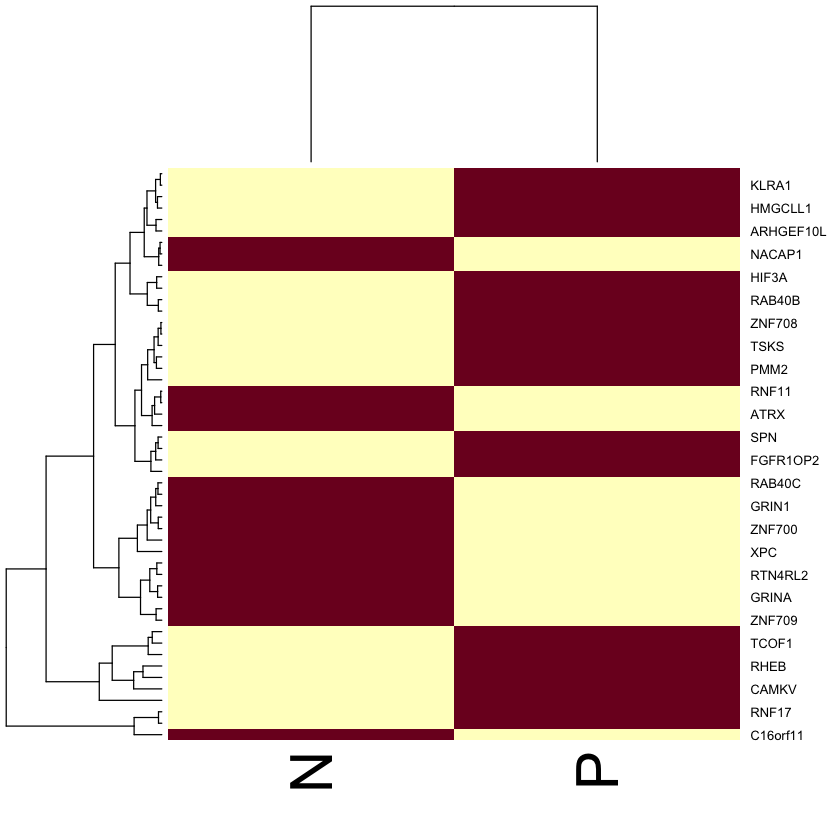

In [40]:
heatmap(ER_PN_df)

### 発現がPR statusと差次的に相関している遺伝子を見つけるために同じ手法を用いる

,statistic.t,parameter.df,p.value,conf.int1,conf.int2,estimate.mean of x,estimate.mean of y,null.value.difference in means,stderr,alternative,method,data.name
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
ARHGEF10L,53.9712483637786,780.003093914087,1.41371441833366e-265,639.09057757753,687.3345184532,665.875800256082,2.66325224071703,0,12.2882565833045,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$PR_Status_nature2012)"
HIF3A,61.1938687529475,780.003667856464,5.4106570078653e-300,668.476799831703,712.785684163176,693.294494238156,2.66325224071703,0,11.2859548852135,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$PR_Status_nature2012)"
RNF17,101.132594964731,780.086159924596,0,230.930767796963,240.07307343223,238.165172855314,2.66325224071703,0,2.32864508912015,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$PR_Status_nature2012)"
C16orf11,83.3346516538683,780.034586509725,0,299.066996517329,313.496383764361,308.944942381562,2.66325224071703,0,3.67532213865837,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$PR_Status_nature2012)"
TSKS,69.6821174089113,780.006811973456,0,560.815057024887,593.328348864998,579.734955185659,2.66325224071703,0,8.28148920272539,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$PR_Status_nature2012)"
LRRTM1,86.7321227219599,780.018713867753,0,423.547799628014,443.164108182486,436.019206145967,2.66325224071703,0,4.99648734868941,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$PR_Status_nature2012)"
LRRTM3,100.029337997642,780.092970381396,0,219.838885898028,228.639987341409,226.902688860435,2.66325224071703,0,2.24173668554125,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$PR_Status_nature2012)"
CAMKV,66.6420140871503,780.009086149634,0,463.787043666032,491.938948651509,480.526248399488,2.66325224071703,0,7.17059654790522,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$PR_Status_nature2012)"
OVCH1,86.9325860803387,780.027380384464,0,350.987344522314,367.204716937353,361.759282970551,2.66325224071703,0,4.13074138158015,two.sided,Welch Two Sample t-test,"as.numeric(merge_df[, j]) and as.numeric(merge_df$PR_Status_nature2012)"


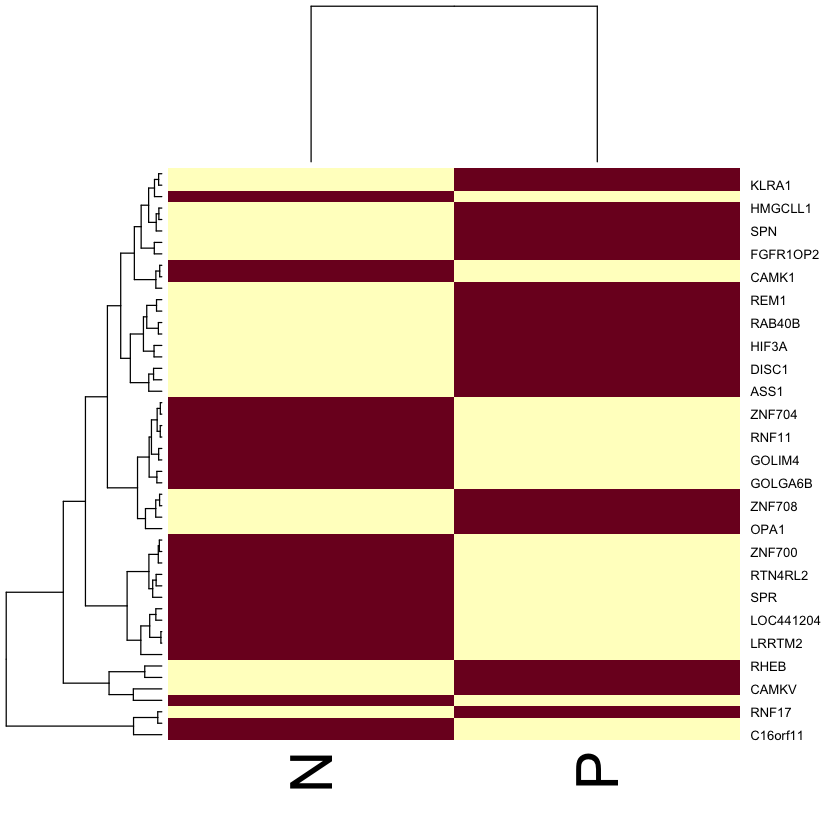

In [41]:
PR_status_t_df <- data.frame(matrix(rep(NA, 1), nrow=1))[numeric(0), ]

for (j in 1:(ncol(sdLarger_genomicMatrix_Larger0.5_t))){
    PR_status_htest <- t.test(as.numeric(merge_df[ ,j]),as.numeric(merge_df$PR_Status_nature2012))
    PR_status_htest <- as.data.frame(t(data.frame(unlist(PR_status_htest))))
    PR_status_t_df <- rbind(PR_status_t_df, PR_status_htest)
}

rownames(PR_status_t_df) <- colnames(sdLarger_genomicMatrix_Larger0.5_t)
PR_status_t_df[order(PR_status_t_df$p.value), ]

gene_mean_list_P <- list()
gene_mean_list_N <- list()

for (k in (1:50)){
    gene_list_P <- list()
    gene_list_N <- list()
    gene <- rownames(PR_status_t_df)[k]
    for (l in (1:nrow(merge_df))){
        if (merge_df[l, "PR_Status_nature2012"]=="Positive"){
            gene_list_P <- c(gene_list_P, list(merge_df[l, gene]))
        }else{
            gene_list_N <- c(gene_list_N, list(merge_df[l, gene]))
        }
    }
    gene_df_P <- as.data.frame(gene_list_P)
    gene_P_mean <- mean(as.numeric(gene_df_P))
    
    gene_df_N <- as.data.frame(gene_list_N)
    gene_N_mean <- mean(as.numeric(gene_df_N))
    
    gene_mean_list_P <- c(gene_mean_list_P, list(gene_P_mean))
    gene_mean_list_N <- c(gene_mean_list_N, list(gene_N_mean))   
}

P <- t(as.data.frame(gene_mean_list_P))
N <- t(as.data.frame(gene_mean_list_N))
PR_PN_df <- cbind(P, N)


rownames(PR_PN_df) <- rownames(PR_status_t_df)[1:50]
colnames(PR_PN_df) <- c("P", "N")

heatmap(PR_PN_df)

# 3. PAM50遺伝子特性と比較せよ
PAM50遺伝子特性は、4つの亜型のうちの１つとして腫瘍を分類するために、外科的に切除された乳がんサンプルにおける50個もの遺伝子の発現量を測定する。

- PAM50遺伝子のリストとsection2で見つかったトップ遺伝子と比較する。:
> UBE2T, BIRC5, NUF2, CDC6, CCNB1, TYMS, MYBL2, CEP55, MELK,
NDC80, RRM2, UBE2C, CENPF, PTTG1, EXO1, ORC6L, ANLN, CCNE1,
CDC20, MKI67, KIF2C, ACTR3B, MYC, EGFR, KRT5, PHGDH, CDH3, MIA,
KRT17, FOXC1, SFRP1, KRT14, ESR1, SLC39A6, BAG1, MAPT, PGR, CXXC5,
MLPH, BCL2, MDM2, NAT1, FOXA1, BLVRA, MMP11, GPR160, FGFR4,
GRB7, TMEM45B, ERBB2

In [52]:
#PAM_50gene_list
PAM_50gene_names <- list("UBE2T", "BIRC5", "NUF2", "CDC6", "CCNB1", "TYMS", "MYBL2", "CEP55", "MELK", "NDC80", 
                     "RRM2", "UBE2C", "CENPF", "PTTG1", "EXO1", "ORC6L", "ANLN", "CCNE1", "CDC20", "MKI67", 
                     "KIF2C", "ACTR3B", "MYC", "EGFR", "KRT5", "PHGDH", "CDH3", "MIA", "KRT17", "FOXC1", 
                     "SFRP1", "KRT14", "ESR1", "SLC39A6", "BAG1", "MAPT", "PGR", "CXXC5", "MLPH", "BCL2", 
                     "MDM2", "NAT1", "FOXA1", "BLVRA", "MMP11", "GPR160", "FGFR4", "GRB7", "TMEM45B", "ERBB2")

#section2で見つかったトップ遺伝子
#rownames(ER_status_t_df)[1:50]

#いくつ同じか知る
j <- 0
for (i in 1:length(PAM_50gene_names)){
    if (is.element(PAM_50gene_names[i], rownames(ER_status_t_df)[1:50])==TRUE){
        print(PAM_50gene_names[i])
        j <- j + 1
    }
}
print(j)


#rownames(ER_status_t_df)には全部入っているよね？
j <- 0
for (i in 1:length(PAM_50gene_names)){
    if (is.element(PAM_50gene_names[i], rownames(ER_status_t_df))==TRUE){
        #print(PAM_50gene_names[i])
        j <- j + 1
    }
}
print(j) #50→全部入っている！


#rownames(ER_status_t_df)には全部入っているよね？
j <- 0
for (i in 1:length(PAM_50gene_names)){
    if (is.element(PAM_50gene_names[i], rownames(merge_df))==TRUE){
        #print(PAM_50gene_names[i])
        j <- j + 1
    }
}
print(j) #0

[1] 0
[1] 50
[1] 0


In [54]:
class(PAM_50gene_names[4])

[1] "list"

In [56]:
ER_status_t_df[, as.character(PAM_50gene_names[4])]

ERROR: Error in `[.data.frame`(ER_status_t_df, , as.character(PAM_50gene_names[4])): undefined columns selected


In [58]:
t(ER_status_t_df[, as.character(PAM_50gene_names[4])])

ERROR: Error in `[.data.frame`(ER_status_t_df, , as.character(PAM_50gene_names[4])): undefined columns selected


In [ ]:
#患者を4分類してみる
#どちらでも良いがmerge_dfを使用することにする

for (i in 1:length(PAM_50gene_names)){
    merge_df[, PAM_50gene_names[i]]
}